In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from datetime import datetime
import unicodedata
from unidecode import unidecode
import re
import copy
import pickle
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
import pickle

# Load game events
with open('data/game_events.pkl', 'rb') as f:
    game_events = pickle.load(f)

# Load mappings of names to player ids
with open('data/all_name_to_id.pkl', 'rb') as f:
    all_name_to_id = pickle.load(f)

with open('data/first_name_to_id.pkl', 'rb') as f:
    first_name_to_id = pickle.load(f)

with open('data/last_name_to_id.pkl', 'rb') as f:
    last_name_to_id = pickle.load(f)

# Load player ratings dictionary (key = player id)
with open('data/player_ratings.pkl', 'rb') as f:
    player_ratings = pickle.load(f)

# Load regular table of players (just in case)
with open('data/all_fifa_player_ratings.pkl', 'rb') as f:
    all_fifa_ratings = pickle.load(f)


In [7]:
#function to find player id if their name number combination is unique enough 
def find_player_id(first_key,last_key,first_name_to_id_dict,last_name_to_id_dict):
    #get player id(s) given jersey and team info as sets, last name takes priority
    try:
        first_player_id = first_name_to_id_dict[first_key]
    except:
        first_player_id = set()
    try:
        last_player_id = last_name_to_id_dict[last_key]
    except:
        last_player_id = set()
    if len(last_player_id) == 1:
        player_id = list(last_player_id)[0]
    elif len(first_player_id) == 1:
        player_id = list(first_player_id)[0]
    else:
        cand = first_player_id.intersection(last_player_id)
        if len(cand) == 1:
            player_id = list(cand)[0]
        else:
            player_id = None
    return player_id

In [8]:

def search_name_in_table(first,last,table):
    name = first.lower() + "-" + last.lower()
    table_name = table[(table['player_url'].str.contains(name))]['player_id']
    player_id = set([v for v in table_name])
    if len(player_id)  == 1:
        return list(player_id)[0]
    else:
        player_id = None
    if player_id is None:
        table_name = table[(table['player_url'].str.contains(first.lower())) & (table['player_url'].str.contains(last.lower()))]['player_id']
        player_id = set([v for v in table_name])
        if len(player_id)  == 1:
            return list(player_id)[0]
        else:
            return None

In [9]:
#function to get fifa_ratings for each player on the field
def lineup_to_fifa(first_name_to_id_dict,last_name_to_id_dict,all_name_to_id_dict,player_table,player_rating_dict,lineup,roster_dict,fifa_year, team_name):
    #get roster names from numbers
    lineup_names = []
    lineup_numbers = []
    for key in lineup:
        lineup_numbers.append(key)
        name = roster_dict[key]
        name = unidecode(name).upper().split()
        lineup_names.append([name[0],name[-1]])
    #get nuber of players on field 
    n = len(lineup_names)
    #initialize stat list fo reach player 
    goalkeeping = []
    offense = []
    defense = []
    no_found = {}
    for j in range(n):
        #key for first name dictionary 
        first_key = tuple((lineup_names[j][0],team_name,lineup_numbers[j]))
        #key for last name dictionary 
        last_key = tuple((lineup_names[j][1],team_name,lineup_numbers[j]))
        #find player id 
        player_id = find_player_id(first_key,last_key,first_name_to_id_dict,last_name_to_id_dict)
        #if no one is found, switch order of first and last name (asian players tend to have this ordering)
        if player_id is None:
            player_id = find_player_id(last_key,first_key,first_name_to_id_dict,last_name_to_id_dict)
        #if no one is found, check to see if their first and last name combination is unique 
        if player_id is None:
            name = tuple((first_key[0],last_key[0]))
            if name in all_name_to_id_dict:
                cand = all_name_to_id_dict[name]
                if len(cand) == 1:
                    player_id = list(cand)[0]
        #if not found, look for thier name in the player database (time consuming)
        if player_id is None:
            player_id = search_name_in_table(first_key[0],last_key[0],player_table)
        #if not found, add to dictionary 
        if player_id is None:
            #print("player not found")
            no_found.update({tuple((lineup_names[j][0],lineup_names[j][1],team_name,lineup_numbers[j])):1})
            continue
        

        #Once we find a player we can gather their stats
        #if they have this exact player's stats ina  fifa version that corresponds to the year we want we are done 
        if fifa_year in player_rating_dict[player_id]:
            stats = player_rating_dict[player_id][fifa_year]
        #otherwise, get closest fifa year
        else:
            #prefer using an earluer year vs a later year 
            years = list(player_rating_dict[player_id].keys())
            years_diff = [abs(v + 0.5 -fifa_year) for v in player_rating_dict[player_id]]
            #get index order from smallest to largest
            closest_year = years[sorted(range(len(years)), key=lambda x: years_diff[x])[0]]
            #get stats ffrom closest year
            stats = player_rating_dict[player_id][closest_year]
        #add stats to list 
        offense.append(stats[0])
        defense.append(stats[1])
        goalkeeping.append(stats[2])
    #get goal
    gk = goalkeeping.index(max(goalkeeping))
    goalkeeping = max(goalkeeping)
    offense.pop(gk)
    defense.pop(gk)

    return [goalkeeping,offense,defense],no_found
    

In [10]:
#function to get fifa_ratings for each player on the field
def lineup_to_fifa_substitution(first_name_to_id_dict,last_name_to_id_dict,all_name_to_id_dict,player_table,player_rating_dict,lineup,roster_dict,fifa_year, team_name):
    #get roster names from numbers
    lineup_names = []
    lineup_numbers = []
    for key in lineup:
        lineup_numbers.append(key)
        name = roster_dict[key]
        name = unidecode(name).upper().split()
        lineup_names.append([name[0],name[-1]])
    #get nuber of players on field 
    n = len(lineup_names)
    #initialize stat list fo reach player 
    offense = []
    defense = []
    no_found = {}
    for j in range(n):
        #key for first name dictionary 
        first_key = tuple((lineup_names[j][0],team_name,lineup_numbers[j]))
        #key for last name dictionary 
        last_key = tuple((lineup_names[j][1],team_name,lineup_numbers[j]))
        #find player id 
        player_id = find_player_id(first_key,last_key,first_name_to_id_dict,last_name_to_id_dict)
        #if no one is found, switch order of first and last name (asian players tend to have this ordering)
        if player_id is None:
            player_id = find_player_id(last_key,first_key,first_name_to_id_dict,last_name_to_id_dict)
        #if no one is found, check to see if their first and last name combination is unique 
        if player_id is None:
            name = tuple((first_key[0],last_key[0]))
            if name in all_name_to_id_dict:
                cand = all_name_to_id_dict[name]
                if len(cand) == 1:
                    player_id = list(cand)[0]
        #if not found, look for thier name in the player database (time consuming)
        if player_id is None:
            player_id = search_name_in_table(first_key[0],last_key[0],player_table)
        #if not found, add to dictionary 
        if player_id is None:
            #print("player not found")
            no_found.update({tuple((lineup_names[j][0],lineup_names[j][1],team_name,lineup_numbers[j])):1})
            continue
        

        #Once we find a player we can gather their stats
        #if they have this exact player's stats ina  fifa version that corresponds to the year we want we are done 
        if fifa_year in player_rating_dict[player_id]:
            stats = player_rating_dict[player_id][fifa_year]
        #otherwise, get closest fifa year
        else:
            #prefer using an earluer year vs a later year 
            years = list(player_rating_dict[player_id].keys())
            years_diff = [abs(v + 0.5 -fifa_year) for v in player_rating_dict[player_id]]
            #get index order from smallest to largest
            closest_year = years[sorted(range(len(years)), key=lambda x: years_diff[x])[0]]
            #get stats ffrom closest year
            stats = player_rating_dict[player_id][closest_year]
        #add stats to list 
        offense.append(stats[0])
        defense.append(stats[1])

    return [offense,defense],no_found
    

# Expected Goal EDA
In this section, I will perform an exploratory data analysis on the xG (expected goals) of shots in EPL games between 2015 and 2022. For each game, I have a list of periods defined by game state-changing events, such as goals, substitutions, extra time, half endings, and ejections. Within each period, I have its duration, the players on the field for each team, and the xG scored by both sides. For each player, I have acquired their FIFA rating for that season, and I use the sum of each team's FIFA ratings to measure their offensive and defensive abilities. I then aggregate all statistics across clubs and FIFA years.

## Reading In Data

In [11]:
#keep track of how many matched between a player and their FIFA rating failed (should be 0)
failure_counter = 0
# list of home team offensive ratings 
home_offense = []
# list of home team defensive ratings
home_defense = []

# list of away team offensive ratings 
away_offense = []
# list of away team defensive ratings 
away_defense = []

# home_team xg dictionary (keys are (club,FIFA Year))
home_xg = {}
# away team xg dictionary keys are (club,FIFA Year))
away_xg = {}

#get unfound players dictionary 
unfound = {}

#get id to name dictionary 
id_to_participant_dict = {}
#iterate over all games 
for key in game_events:
    #get game 
    game = game_events[key]
    #get rosters
    home_team_name = game['home_team_name']
    home_roster_dict = game['home_team_roster']
    #get away team and roster
    away_team_name = game['away_team_name']
    away_roster_dict = game['away_team_roster']
    #add participants to dictionary
    id_to_participant_dict[key] = [home_team_name,away_team_name]

    #get fifa year 
    fifa_year = game['year']

    
    # get number of events that occured in game 
    n =  len(game['data'])
    #measure fatigue (initialized at 0 for all players)
    fatigue_home = {v:0 for v in game['data'][0]['lineups'][home_team_name]}
    fatigue_away = {v:0 for v in game['data'][0]['lineups'][away_team_name]}
    #iterate over all events
    for j in range(n):
        #get lineups at time of event
        lineup_home = game['data'][j]['lineups'][home_team_name]
        lineup_away = game['data'][j]['lineups'][away_team_name]
        #get home team player FIFA stats for all players on field 
        home_stats,no_found = lineup_to_fifa(first_name_to_id,last_name_to_id,all_name_to_id,all_fifa_ratings,player_ratings,lineup_home,home_roster_dict,fifa_year,home_team_name)
        #if error finding player (shouldn't run)
        if(len(no_found))>0:
            print('player not found ')
            unfound.update(no_found)
            failure_counter += 1
        #get away team player FIFA stats for all players on field 
        away_stats,no_found = lineup_to_fifa(first_name_to_id,last_name_to_id,all_name_to_id,all_fifa_ratings,player_ratings,lineup_away,away_roster_dict,fifa_year,away_team_name)
        #if error finding player (shouldn't run)
        if(len(no_found))>0:
            print('what')
            unfound.update(no_found)
            failure_counter += 1
        
        #get length of period 
        time_elapse = game['data'][j]['time_end'] - game['data'][j]['time_start']

        #for player on field, add alapsed time to length of time played. If player is new, start at 0
        for key in lineup_home:
            if key in fatigue_home:
                fatigue_home[key]+= time_elapse
            else:
                fatigue_home[key] = time_elapse

        for key in lineup_away:
            if key in fatigue_away:
                fatigue_away[key]+= time_elapse
            else:
                fatigue_away[key] = time_elapse
        
        #measure fatigue of each team as average minutes played 
        home_field_fatigue = np.mean([fatigue_home[v] for v in lineup_home])
        away_field_fatigue = np.mean([fatigue_away[v] for v in lineup_away])


        # get home team offense and defense stats 
        home_offense = sum(home_stats[1])
        home_defense = sum(home_stats[2])
        #aget away team offense and defense stats
        away_offense = sum(away_stats[1])
        away_defense = sum(away_stats[2])
        #get home and away score during period 
        home_score= game['data'][j]['score'][home_team_name]
        away_score = game['data'][j]['score'][away_team_name]
        #get half and extra time info during period
        half = game['data'][j]['half']
        extra = game['data'][j]['extra_time']
        
        #get club name and year tuple 
        home_tuple = tuple((home_team_name,fifa_year))

        home_game_state = {'xg':game['data'][j]['xg'][home_team_name],
             'time_elapsed': time_elapse,
             'offense': home_offense,
             'defense': home_defense,
             'opp_offense': away_offense,
             'opp_defense':away_defense,
             'score_differential': home_score - away_score,
             'half':half,
             'extra_time':extra,
             'fatigue':home_field_fatigue,
             'opp_fatigue':away_field_fatigue}
        
        away_game_state = {'xg':game['data'][j]['xg'][away_team_name],
             'time_elapsed': time_elapse,
             'offense': away_offense,
             'defense': away_defense,
             'opp_offense': home_offense,
             'opp_defense':home_defense,
             'score_differential': away_score - home_score,
             'half':half,
             'extra_time':extra,
             'fatigue':away_field_fatigue,
             'opp_fatigue':home_field_fatigue}

        #add to xg dictionary 
        if home_tuple in home_xg:
            home_xg[home_tuple].append(copy.deepcopy(home_game_state))
        else:
            home_xg[home_tuple] = [copy.deepcopy(home_game_state)]

        away_tuple = tuple((away_team_name,fifa_year))
        if away_tuple in away_xg:
            away_xg[away_tuple].append(copy.deepcopy(away_game_state))
        else:
            away_xg[away_tuple] = [copy.deepcopy(away_game_state)]
        

    
    


## Covariate Overview
We measure the following features
 + Team offensive rating (continuous): Sum of player FIFA offensive ratings for team
 + Opponent defensive rating (continuous): Sum of player FIFA defensive ratings for opponent
 + Score differential (factor): Score - Opponent's score. Factored to be <-3, -2, -1, 0, 1,2, > 3
 + Home field advantage (Binary)
 + Half (Binary)
 + Extra Time (Binary)
 + Fatigue Difference (continuous): Average minutes played fatigue - Opponent's average minutes played 

We will now see how the expected goals per minute varies with each feature. For simplicity, we will normalize to goals/90 min.

In [12]:
#[[game['data'][j]['xg'][away_team_name], time_elapse, away_offense,away_defense,home_offense, home_defense,away_score - home_score, half, extra,away_format, home_format,home_field_fatigue,away_field_fatigue]]    
#0:xg, 
#1:time
#2:team offense
#3:team defense
#4: opp offense
#5 opp defense 
#6:score differential
#7:half
#8: extra time
#9: team formation
#10: opp formation
#11: home fatigue
#12: away fatigue 

### Offensive Rating

Average scoring rate seems very linear in offensive skill sum and as we shall see, is the largest determinant in a team's goal scoring rate.

Text(0.5, 1.0, 'Xg/90 vs Offensive Rating')

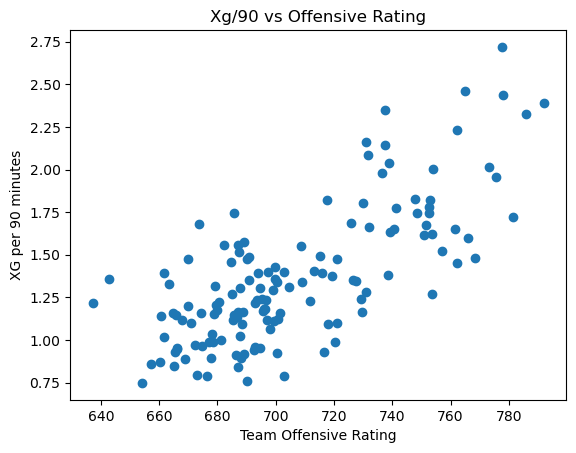

In [13]:
#keep track of offensive skill for each team (on average)
offensive_skill = []
#get goal scoring rate per 90 minutes
rate = []
for key in home_xg:
    #get data for team during this fifa season
    data = home_xg[key]
    #get average FIFA offensive rating over all games played
    offensive_skill.append(np.mean([v['offense'] for v in data ]))
    #get average rate of 
    rate.append(np.sum([v['xg'] for v in data ])/np.sum([v['time_elapsed'] for v in data ]) * 90)
plt.scatter(offensive_skill,rate)
plt.xlabel("Team Offensive Rating")
plt.ylabel("XG per 90 minutes")
plt.title('Xg/90 vs Offensive Rating')

### Opponent's Defensive Skill
We see that the goal scoring rate is linearly dependent on the opponent's defensive skill rating. As expected, the better the opponent on defensive, the less goals we expect to score on average. 

Text(0.5, 1.0, 'Xg/90 Below Average vs Opponent Defensive Rating')

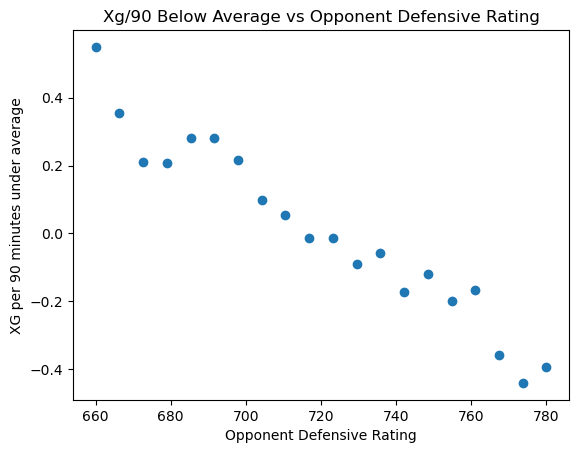

In [14]:
#list of average xg rate for teams 
avg_rates = []
#list of defensive skill 
skill_edge = []
#rate of gaol scored 
rate = []
bins = 20
#minimum skill rating 
m = 660
#maximum skill rating 
n = 780
#size of ins 
bin_size = (n-m)/(bins - 0.01)
#defensive ability 
defensive_ability  = [0 for _ in range(bins)]
defensive_minutes  = [0 for _ in range(bins)]
for key in home_xg:
    data = home_xg[key]
    #get average scoring rate for this team 
    avg_rate = np.sum([v['xg'] for v in data if v['time_elapsed'] > 3])/np.sum([v["time_elapsed"] for v in data if v['time_elapsed'] > 3])
    #for each period, measure defensive team ability and xg scored 
    for period in data:
        #get opp defensive ability 
        defense = period['opp_defense']
        #bin opp defensive ability 
        if defense < m:
            b = 0
        elif defense > n:
            b = bins-1
        else:
            b = int((defense - m)/bin_size)
        #get deviation from how many xg are expected
        defensive_ability[b] += period['xg'] - avg_rate*period['time_elapsed']
        #get minutes
        defensive_minutes[b]+= period['time_elapsed']
#get range of defensive teams 
range_values = np.linspace(m, n, bins)
#get defensive effect (avg deviation between xg allowed and what opponent's normally score )
def_effect = [90*defensive_ability[v]/defensive_minutes[v] for v in range(len(defensive_ability))]
plt.scatter(range_values,def_effect)
plt.xlabel("Opponent Defensive Rating")
plt.ylabel("XG per 90 minutes under average")
plt.title('Xg/90 Below Average vs Opponent Defensive Rating' )

Text(0.5, 1.0, 'First half Scoring Rate Minus Second Half Scoring Rate (xg/90)')

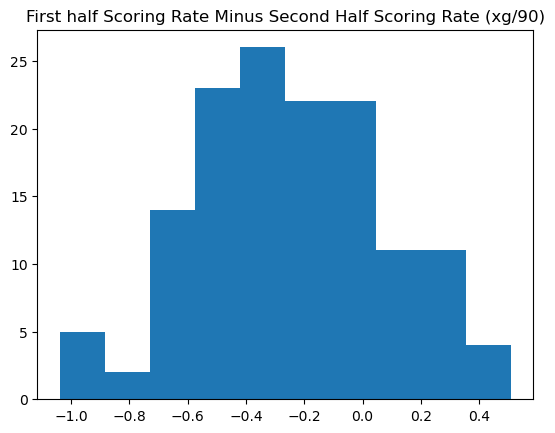

In [15]:
#list of goal scoring rates in the first half
first_half_rate = []
#list of goal scoring rates in the second half
second_half_rate = []
#list of differences between first and second half rates 
half_effect = []
#iterate over clubs and year 
for key in home_xg:
    #get data for this club 
    data = home_xg[key]
    #xg in first half 
    H1 = []
    #xg in second half 
    H2 = []
    #minutes played in the first half 
    M1 = []
    #minutes played in the secodn half 
    M2 = []
    #for period in data 
    for period in data:
        half = period['half']
        if half == 1:
            H1.append(period['xg'])
            M1.append(period['time_elapsed'])
        elif half == 2:
            H2.append(period['xg'])
            M2.append(period['time_elapsed'])
    first_half_rate.append(90*sum(H1)/sum(M1))
    second_half_rate.append(90*sum(H2)/sum(M2))
    half_effect.append(90*sum(H1)/sum(M1) - 90*sum(H2)/sum(M2))

plt.hist(half_effect)
plt.title("First half Scoring Rate Minus Second Half Scoring Rate (xg/90)")

Text(0.5, 1.0, 'Regular Time Scoring Rate Minus Extra Time Scoring Rate (xg/90)')

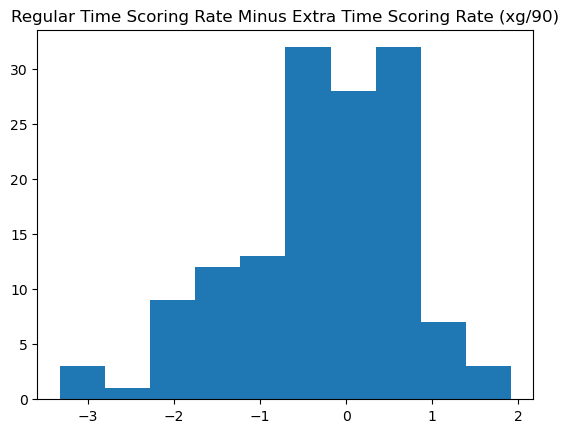

In [16]:
#list of difference in scoring rates when in extra time vs not 
extra_time_effect = []
#iterate over teams and years 
for key in home_xg:
    data = home_xg[key]
    #get xg in extra time 
    extra = []
    #get length of extra time period
    extra_min = []
    #get xg in extra time 
    regular = []
    #get length of regular time period
    regular_min = []
    #iterate over periods
    for period in data:
        extra_time = period['extra_time']
        half = period['half']
        if extra_time == 1 and half == 1:
            extra.append(period['xg'])
            extra_min.append(period['time_elapsed'])
        elif extra_time == 0 and half == 1:
            regular.append(period['xg'])
            regular_min.append(period['time_elapsed'])
    extra_time_effect.append(90*sum(regular)/sum(regular_min) - 90*sum(extra)/sum(extra_min))

plt.hist(extra_time_effect)
plt.title("Regular Time Scoring Rate Minus Extra Time Scoring Rate (xg/90)")

Text(0.5, 1.0, 'Home Scoring Average - Away Scoring Average (xg/90)')

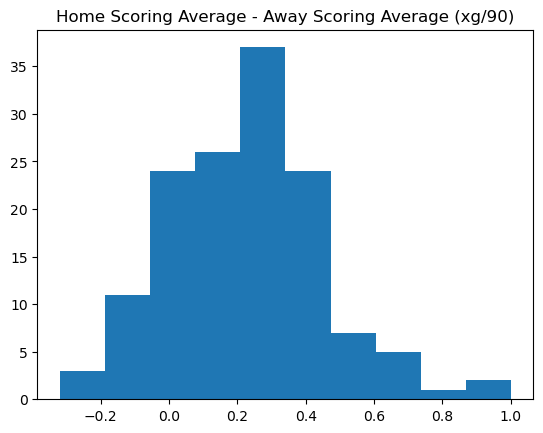

In [17]:
#list of home field effects
home_field_effect = []
#iterate over teams and years 
for key in home_xg:
    #get team data
    data = home_xg[key]
    #get average scoring rate for this team 
    home_avg_rate = np.sum([v['xg'] for v in data if v['time_elapsed'] > 3])/np.sum([v['time_elapsed'] for v in data if v['time_elapsed'] > 3])
    if key in away_xg:
        data = away_xg[key]
        away_avg_rate =np.sum([v['xg'] for v in data if v['time_elapsed'] > 3])/np.sum([v['time_elapsed'] for v in data if v['time_elapsed'] > 3])
        home_field_effect.append(90*home_avg_rate - 90*away_avg_rate)
plt.hist(home_field_effect)
plt.title("Home Scoring Average - Away Scoring Average (xg/90)")
    

## Modelling Expected Goals 

Seeing as there are no non-linear effects amongst on main covariates, a linear model seems sufficient for estimating expected goals.
Our estimand of interest is a team's expected goals/min $r$. For each period $i$ of length $t_i$ we observe a team's expected goals scored $Y_i$. We model $Y_i \sim [r_it_i,t_i\sigma^2]$ where $r_i$ is the expected goals per minute.Our covariates are as follows
 + Team offensive rating (continuous): Sum of player FIFA offensive ratings for team
 + Opponent defensive rating (continuous): Sum of player FIFA defensive ratings for opponent
 + Score differential (factor): Score - Opponent's score. Factored to be <-2, -2, -1, 0, 1,2, > 2
 + Home field advantage (Binary)
 + Half (Binary)
 + Extra Time (Binary)
 + Fatifue Difference (continuous): Average minutes played fatigue - Opponent's average minutes played 

We let $r_i = x_i^T\beta$ where $x_i$ is observation $i$'s covariate vector and $\beta$ is teh weight vector for each covariate. We transform the data to be $Y_i/t_i$. In this way, each observation has mean $r_i$ and a variance equal to $\sigma^2/t_i$. This model can be fit via a weighted least squares regression. While I have not specified a distribution on $Y_i$, it is certainly not normal as there should be a large mass at 0 since there exists many periods where a team does not get a shot off. Instead we rely ont he fact that the weighted least squares estimate is the best linear unbiased estimate for $\beta$ regardless of distrbution and use boostrap sampling to generate confidence intervals for $\beta$. 


In [18]:
#Weighted linear Regression
#Covariates are offesnive fifa rating, opponent's defensive fifa rating, half, extra time, home/away, score differential (factor), fatigue, team?
#first make each column of dataframe
counter = 0
#get list of data points (game state and xg)
data_list = []

#dictionary mapping score differential to string
score_map = {-2: "down_2",
            -1: "down_1",
             0:"tied",
             1: "up_1",
             2:"up_2"}

for key in game_events:
    #get game id 
    id_game = key
    #get game 
    game = game_events[key]
    #get rosters
    home_team_name = game['home_team_name']
    home_roster_dict = game['home_team_roster']
    #get away team and roster
    away_team_name = game['away_team_name']
    away_roster_dict = game['away_team_roster']


    #get fifa year 
    fifa_year = game['year']

    #formation = game['home_formation']
    #check stats
    n =  len(game['data'])
    #measure fatigue 
    fatigue_home = {v:0 for v in game['data'][0]['lineups'][home_team_name]}
    fatigue_away = {v:0 for v in game['data'][0]['lineups'][away_team_name]}
    for j in range(n):
        lineup_home = game['data'][j]['lineups'][home_team_name]
        lineup_away = game['data'][j]['lineups'][away_team_name]
        #get home stats 
        home_stats,no_found = lineup_to_fifa(first_name_to_id,last_name_to_id,all_name_to_id,all_fifa_ratings,player_ratings,lineup_home,home_roster_dict,fifa_year,home_team_name)
        if(len(no_found))>0:
            continue
        #get home stats 
        away_stats,no_found = lineup_to_fifa(first_name_to_id,last_name_to_id,all_name_to_id,all_fifa_ratings,player_ratings,lineup_away,away_roster_dict,fifa_year,away_team_name)
        if(len(no_found))>0:
            continue
        
        #add time info
        time_elapse = game['data'][j]['time_end'] - game['data'][j]['time_start']

        #get fatigue at start of period
        fatigue_home_before = copy.deepcopy(fatigue_home)
        fatigue_away_before = copy.deepcopy(fatigue_away)

        for key in lineup_home:
            if key in fatigue_home_before:
                continue
            else:
                fatigue_home_before[key] = 0

        for key in lineup_away:
            if key in fatigue_away_before:
                continue
            else:
                fatigue_away_before[key] = 0
        

        for key in lineup_home:
            if key in fatigue_home:
                fatigue_home[key]+= time_elapse
            else:
                fatigue_home[key] = time_elapse

        for key in lineup_away:
            if key in fatigue_away:
                fatigue_away[key]+= time_elapse
            else:
                fatigue_away[key] = time_elapse
        
        #get fatigue measurement 
        home_field_fatigue = np.mean([fatigue_home[v] + fatigue_home_before[v] for v in lineup_home])/2
        away_field_fatigue = np.mean([fatigue_away[v] + fatigue_away_before[v] for v in lineup_away])/2



        #add home stats
        home_offense = sum(home_stats[1])
        home_defense = sum(home_stats[2])
        #add home stats
        away_offense = sum(away_stats[1])
        away_defense = sum(away_stats[2])
        #add xg info
        home_score= game['data'][j]['score'][home_team_name]
        away_score = game['data'][j]['score'][away_team_name]
        #add halfa nd extra time info
        half_marker = game['data'][j]['half']
        extra = game['data'][j]['extra_time']
        #get period length
        period_length = game['data'][j]['time_end'] - game['data'][j]['time_start']
        

        #add data to lists
        SD_home = home_score - away_score
        if SD_home <= -3:
            SD_home = 'down_2_plus'
        elif SD_home >= 3:
            SD_home = 'up_2_plus'
        else:
            SD_home = score_map[SD_home]

        SD_away = away_score - home_score
        if SD_away <= -3:
            SD_away = 'down_3_plus'
        elif SD_away >= 3:
            SD_away = 'up_3_plus'
        else:
            SD_away = score_map[SD_away]

        #get game covariate list
        home_cov_list = {'xg':game['data'][j]['xg'][home_team_name],
                    'period_length': period_length,
                    'game_id': id_game,
                    'offense': home_offense,
                    'defense':home_defense,
                    'opp_offense':away_offense,
                    'opp_defense':away_defense,
                    'half':half_marker,
                    'extra_time': extra,
                    'score_differential':SD_home,
                    'home':1,
                    'fatigue':home_field_fatigue - away_field_fatigue,
                    'groups': tuple((home_team_name,fifa_year)),
                    'goal': int(game['data'][j]['change_type'] == tuple(('goal',home_team_name))),
                    'pause': game['data'][j]['change_type'],
                    'team':home_team_name
                    }
        
        away_cov_list = {'xg':game['data'][j]['xg'][away_team_name],
                    'period_length': period_length,
                    'game_id': id_game,
                    'offense': away_offense,
                    'defense':away_defense,
                    'opp_offense':home_offense,
                    'opp_defense':home_defense,
                    'half':half_marker,
                    'extra_time': extra,
                    'score_differential':SD_away,
                    'home':0,
                    'fatigue':away_field_fatigue - home_field_fatigue,
                    'groups': tuple((away_team_name,fifa_year)),
                    'goal': int(game['data'][j]['change_type'] == tuple(('goal',away_team_name))),
                    'pause': game['data'][j]['change_type'],
                    'team':away_team_name
                    }
        
        data_list.append(copy.deepcopy(home_cov_list))
        data_list.append(copy.deepcopy(away_cov_list))



    
    


In [19]:
#get data dataframe 
data = {
    'id':[v['game_id'] for v in data_list],
    'offense': [v['offense'] for v in data_list],
    'defense': [v['defense'] for v in data_list],
    'opp_offense':[v['opp_offense'] for v in data_list],
    'opp_defense':[v['opp_defense'] for v in data_list],
    'xg': [v['xg'] for v in data_list],
    'period_length': [v['period_length'] for v in data_list],
    'half': [v['half'] for v in data_list],
    'extra_time': [v['extra_time'] for v in data_list],
    'score_differential':[v['score_differential'] for v in data_list],
    'home': [v['home'] for v in data_list],
    'fatigue':[v['fatigue'] for v in data_list],
    'groups':[v['groups'] for v in data_list],
    'goal':[v['goal'] for v in data_list],
    'pause':[v['pause'] for v in data_list],
    'team':[v['team'] for v in data_list]
}
data = pd.DataFrame(data)
#remove periods of 0 time length
data = data[data['period_length'] > 0]
#get empirical goal scoring rate per period
data['xg_rate'] = data['xg']/data['period_length']

In [20]:
#get columns necessary for model
data_with_dummies = data[['id','xg','period_length','offense','defense','half','extra_time','score_differential','home','fatigue','groups','opp_offense','opp_defense','xg_rate']]
#add dummy colums for binary and factor variables 
data_with_dummies = pd.get_dummies(data_with_dummies, columns=['half', 'extra_time', 'home','score_differential'], drop_first=True,dtype = int)
#get test and train split 
data_with_dummies_train, data_with_dummies_test = train_test_split(data_with_dummies, test_size=0.2, random_state=1)

In [21]:
# Independent variables
X_vars = ['offense','opp_defense','fatigue','half_2','extra_time_1','home_1','score_differential_down_3_plus','score_differential_down_2','score_differential_tied','score_differential_up_1','score_differential_up_2','score_differential_up_3_plus']
#parameter dictioanary for bootstrap samples
parameters = {v:[] for v in X_vars}
#add intercept 
parameters.update({'const':[]})
#add intercept to covariate matrix 
X = sm.add_constant(data_with_dummies_train[X_vars])
#get response (xg rate)
y = data_with_dummies_train['xg_rate']
#get weights (period length)
weights = data_with_dummies_train['period_length']
#fit weighted least squares model 
model = sm.WLS(y, X, weights=weights).fit()
#save fitted parameter estimates
beta = model.params

### VIF
To make sure that we do not have collinearity issues, we compute the VIF for each parameter. We see below that the VIF values for all parameters are near 1, indicating that multicollinearity is not a large issue.

In [22]:
#Check VIF 
# Assuming X is your matrix of independent variables (including the constant)
X = sm.add_constant(data_with_dummies_train[X_vars])

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif_data)


                           feature         VIF
0                            const  794.379354
1                          offense    1.051459
2                      opp_defense    1.099192
3                          fatigue    1.048479
4                           half_2    1.106535
5                     extra_time_1    1.031584
6                           home_1    1.066188
7   score_differential_down_3_plus    1.143991
8        score_differential_down_2    1.256785
9          score_differential_tied    1.644333
10         score_differential_up_1    1.528618
11         score_differential_up_2    1.316727
12    score_differential_up_3_plus    1.114590


### Test Data Fit 
We now test our model's fit on the testing set. While the errors are not normally distributed, I believe that the mean errors aggregated by season and club will approximate a normal distribution. Therefore, we aggregate the data at the (club, year) level. The residuals appear to be approximately homoskedastic and normally distributed, as indicated by the scatter plot of residuals versus fitted means and the QQ plot. Additionally, the residuals are centered around zero, except for teams at the extremes. In these cases, very strong teams tend to underperform, while weaker teams tend to overperform. However, the sample size for both of these classes of teams is small, which may affect the robustness of these observations.

In [23]:
#get predicted rates on test set 
X = sm.add_constant(data_with_dummies_test[X_vars])
predictions = model.predict(X)
#add predictions to dataframe 
data_with_dummies_test['predicted_xg_rate'] = predictions
data_with_dummies_test['predicted_xg'] = data_with_dummies_test['predicted_xg_rate']*data_with_dummies_test['period_length']


In [24]:
aggregated_df = data_with_dummies_test.groupby('groups').agg({
    'xg': 'sum',
    'predicted_xg': 'sum'
})

Text(0.5, 1.0, 'Team Season xg - Predicted Expected Goals')

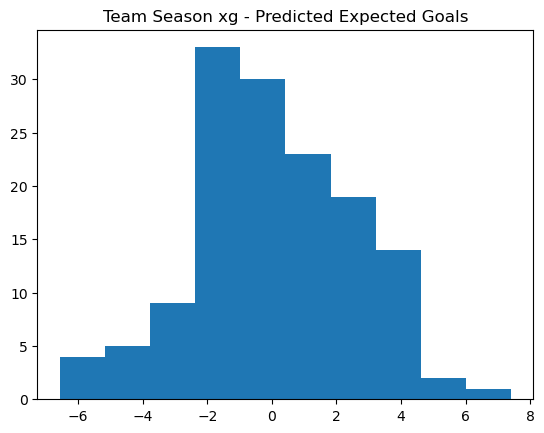

In [25]:
#plt.scatter(aggregated_df['xg'],aggregated_df['predicted_xg'])
plt.hist(aggregated_df['xg'] - aggregated_df['predicted_xg'])
plt.title("Team Season xg - Predicted Expected Goals")

[]

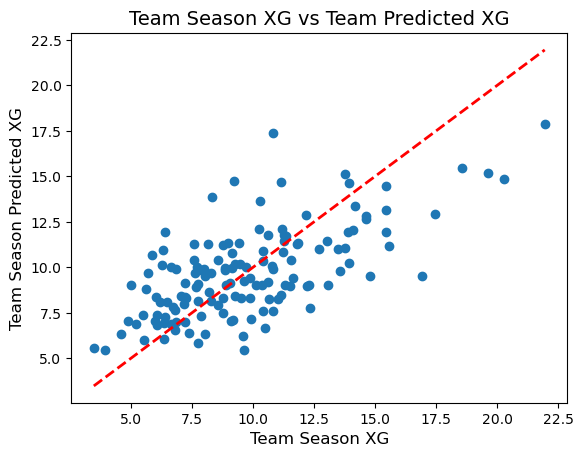

In [26]:
plt.scatter(aggregated_df['xg'],aggregated_df['predicted_xg'])
# Plot the identity line (y = x)
min_val = min(aggregated_df['xg'].min(), aggregated_df['predicted_xg'].min())
max_val = max(aggregated_df['xg'].max(), aggregated_df['predicted_xg'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel("Team Season XG",fontsize = 12)
plt.ylabel("Team Season Predicted XG",fontsize = 12)
plt.title('Team Season XG vs Team Predicted XG',fontsize = 14)

#save plot
plt.savefig("figures/xg_scatter_plot.pdf")

plt.plot()

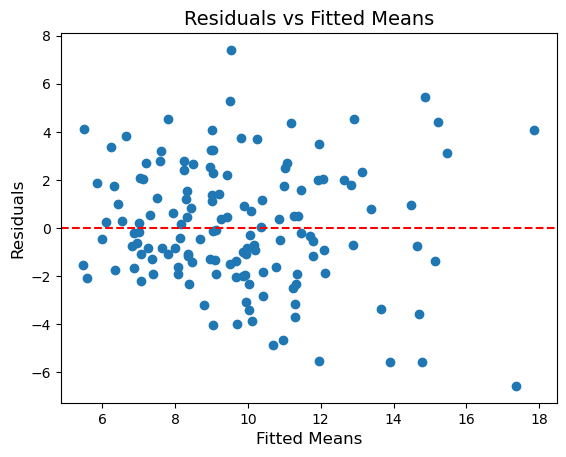

In [27]:
residuals = aggregated_df['xg'] - aggregated_df['predicted_xg']
plt.scatter(aggregated_df['predicted_xg'],residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Means",fontsize = 14)
plt.xlabel("Fitted Means",fontsize = 12)
plt.ylabel('Residuals',fontsize = 12)
#save plot 
plt.savefig("figures/xg_residual_plot.pdf")
plt.show()


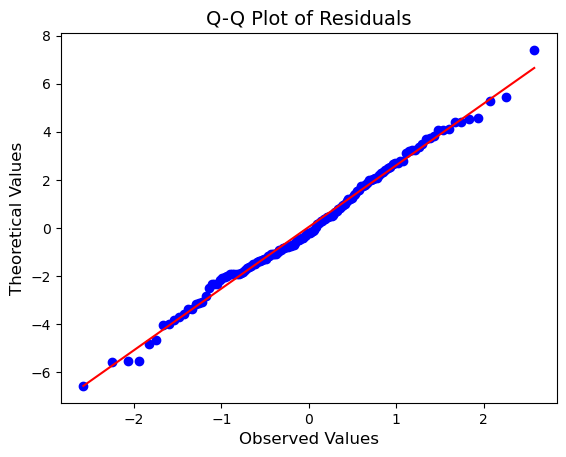

In [28]:
#get residuals 
residuals = aggregated_df['xg'] - aggregated_df['predicted_xg']
#
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals',fontsize = 14)
plt.xlabel('Observed Values',fontsize = 12)
plt.ylabel('Theoretical Values', fontsize = 12)


#save figure 
plt.savefig("figures/xg_qqplot.pdf")
plt.show()

### Final Model Fit and Coefficient Estimate/CI
Given that our model has been shown not to overfit, I fit the final model on the entire dataset. To generate standard errors for each coefficient, I use 5,000 bootstrap samples. Overall, the signs of each parameter align with our intuitions. We observe that the effect of offense is positive, while the effect of defense is negative. Additionally, the effect of extra time is positive, as expected. We also see that the effect of fatigue is negative, indicating that increased fatigue lowers the goal-scoring rate.

Interestingly, the effects when a team is trailing are actually negative, suggesting that being more aggressive in these situations can be detrimental. This contrasts with the positive effect observed when a team is ahead, leading me to believe that when one team becomes more aggressive, the counterattacking team often benefits more. However, when a team is trailing, it is often necessary to be more aggressive, which may increase the variance in the goal-scoring rate.

In [29]:
#rerun model on entire dataset
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
B = 5000
# Assuming df is your DataFrame
# Independent variables
X_vars = ['offense','opp_defense','fatigue','half_2','extra_time_1','home_1','score_differential_down_2','score_differential_down_3_plus','score_differential_tied','score_differential_up_1','score_differential_up_2','score_differential_up_3_plus']
#get parameter fits over bootstrap samples 
parameters = {v:[] for v in X_vars}
#add constant 
parameters.update({'const':[]})
for j in range(B):
    if j%1000 == 0:
        print(j)
    #get bootstrap sample
    bootstrap_sample = data_with_dummies.sample(n=data_with_dummies.shape[0], replace=True)
    #get covaraite matrix 
    X = sm.add_constant(bootstrap_sample[X_vars])
    #get response (xg rate)
    y = bootstrap_sample['xg_rate']
    #get weights (period length)
    weights = bootstrap_sample['period_length']
    #fit model 
    model = sm.WLS(y, X, weights=weights).fit()
    #get parameters values
    beta = model.params
    for key in beta.index:
        if key in parameters:
            parameters[key].append(beta[key])
    



0
1000
2000
3000
4000


In [30]:
# Get predictions for the same data used in the model
beta = model.params
for key in beta.index:
    #update model parameters (for test set prediction)
    model.params[key] = np.mean(parameters[key])


offense
0.0076389123843046604
[0.00714641 0.00814412]


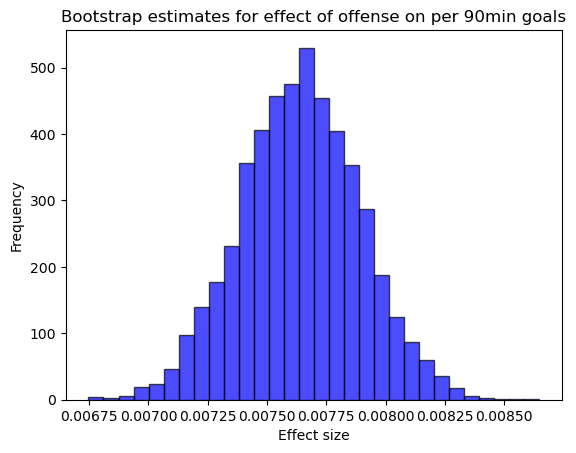

opp_defense
-0.005813226412700718
[-0.00639893 -0.00521631]


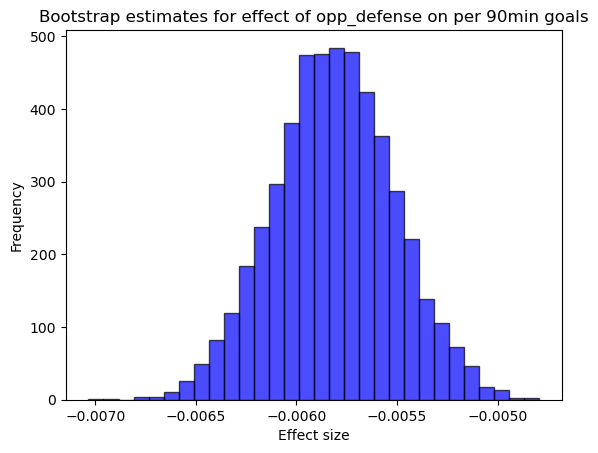

fatigue
-0.0048465772808467256
[-0.00888453 -0.00075394]


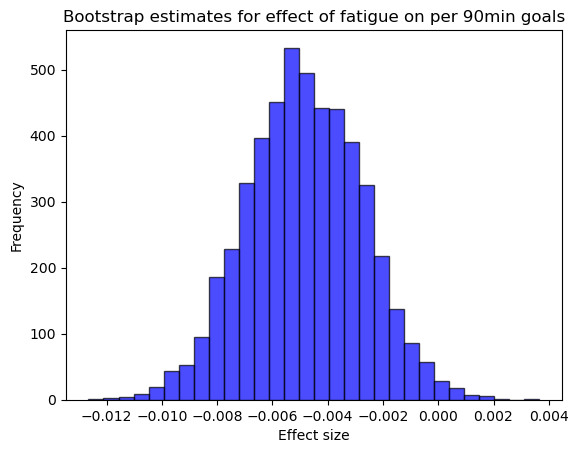

half_2
0.17765398798116872
[0.14118452 0.21583581]


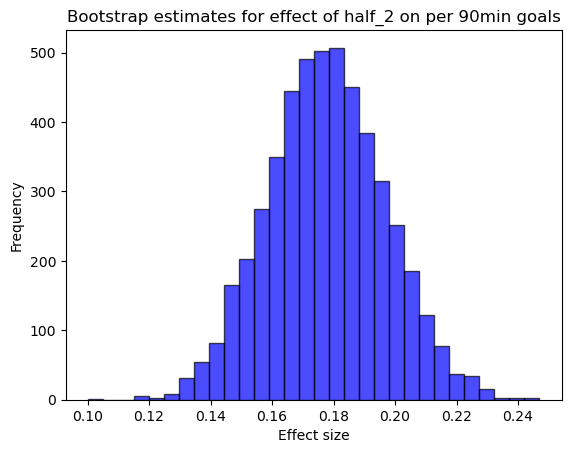

extra_time_1
0.17332803082605683
[0.10260357 0.24124156]


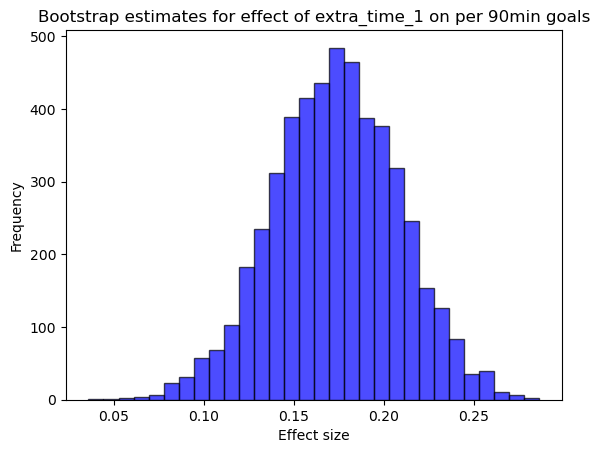

home_1
0.22849294113897098
[0.19178429 0.26457289]


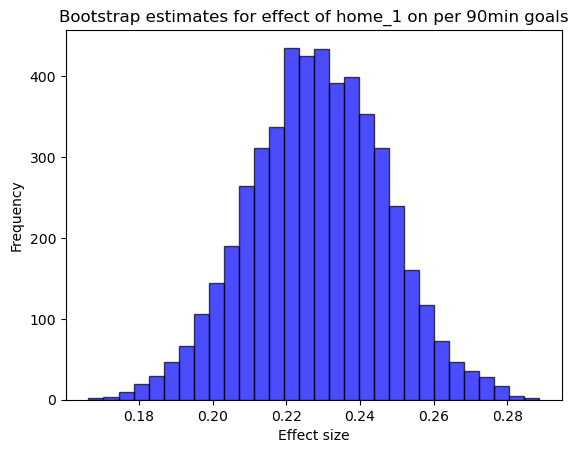

score_differential_down_2
-0.06355708934381712
[-0.1388928   0.01070142]


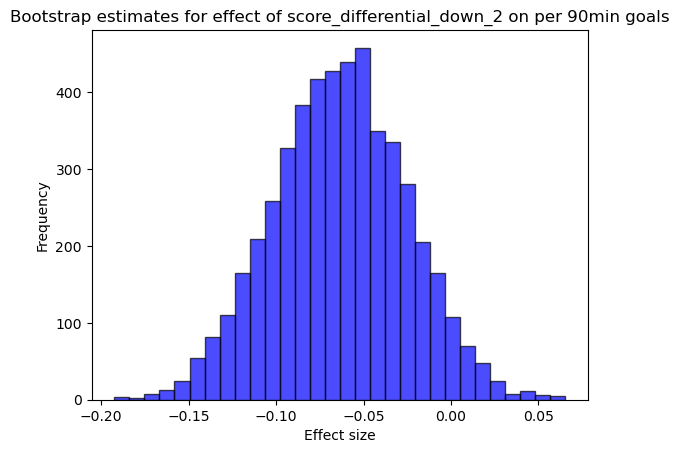

score_differential_down_3_plus
-0.15547778710917226
[-0.25941893 -0.04792655]


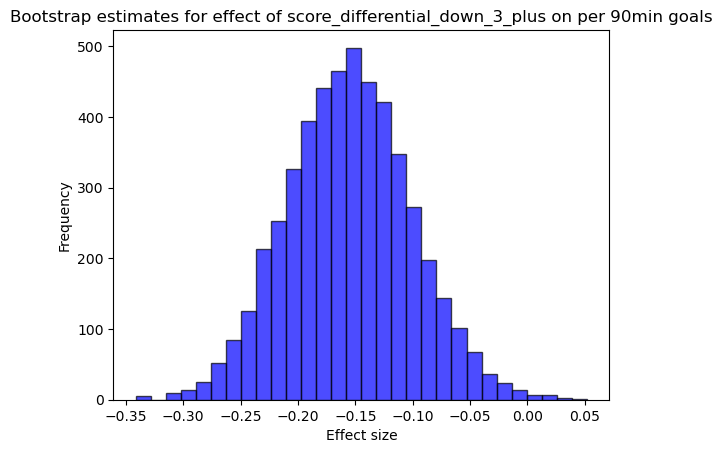

score_differential_tied
-0.015135724762676417
[-0.06270262  0.03317869]


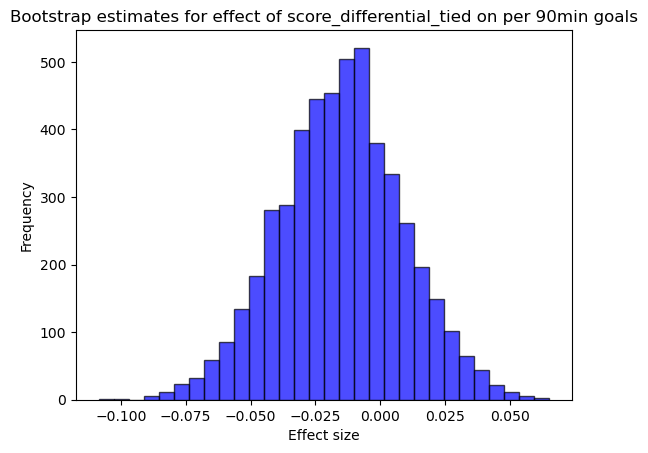

score_differential_up_1
0.034732761021596247
[-0.02577261  0.09477959]


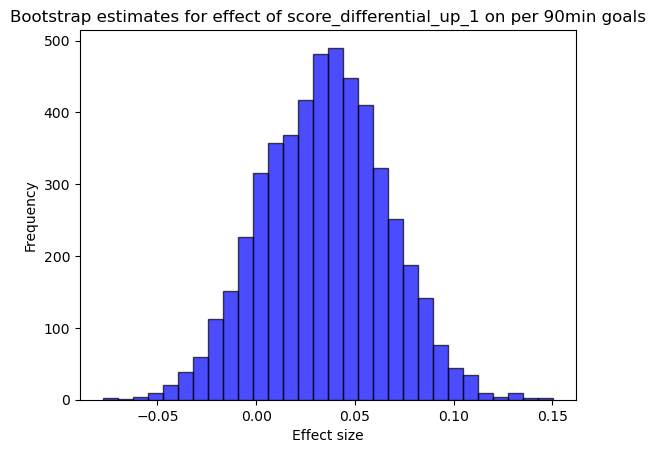

score_differential_up_2
0.16179299760136495
[0.06898666 0.25386397]


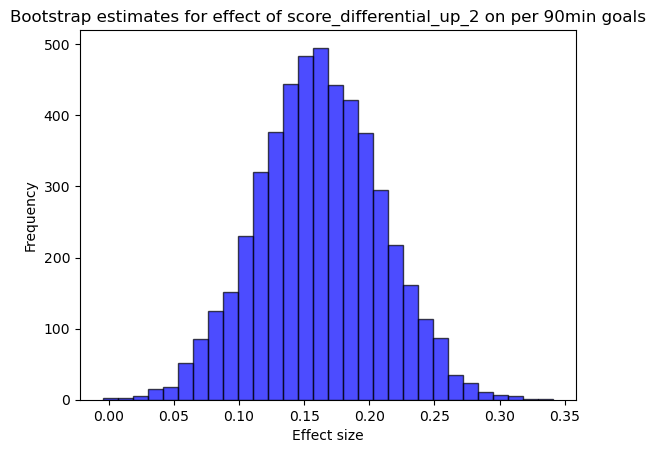

score_differential_up_3_plus
0.08927983758802704
[-0.09724203  0.28425864]


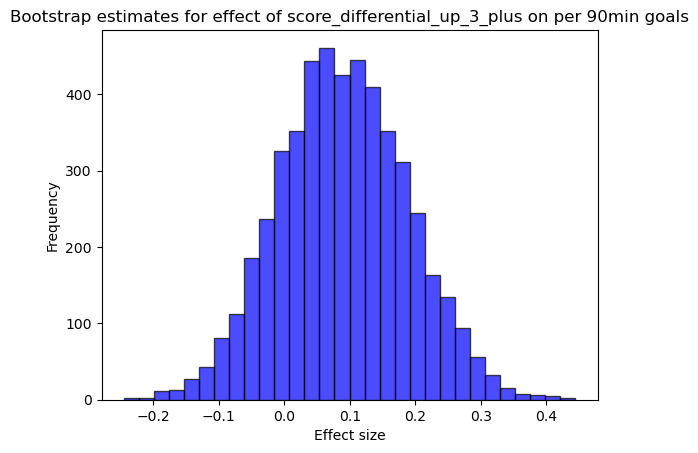

const
-0.2887132257936849
[-0.81591548  0.22886302]


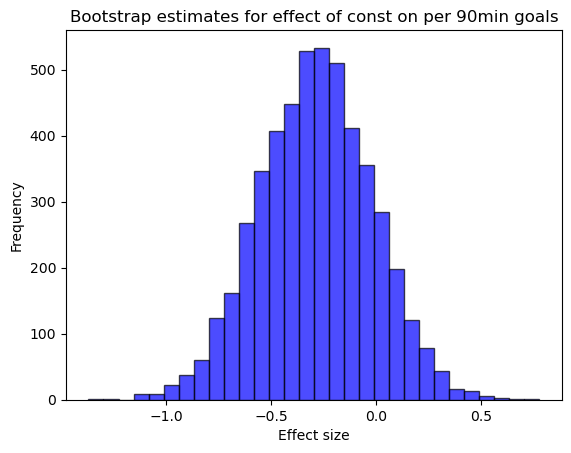

In [31]:
for key in parameters:
    print(key)
    print(90*np.mean(np.array(parameters[key])))
    print(90*np.quantile(np.array(parameters[key]),[0.025,0.975]))

    plt.figure()  # Create a new figure for each plot
    plt.hist(np.array(parameters[key]) * 90, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title("Bootstrap estimates for effect of " + key + " on per 90min goals")
    plt.xlabel('Effect size')
    plt.ylabel('Frequency')
    plt.show()  # D

In [32]:
#get predicted rates on test set 
X = sm.add_constant(data_with_dummies[X_vars])
predictions = model.predict(X)
#add predictions to dataframe 
data_with_dummies['predicted_xg_rate'] = predictions
data_with_dummies['predicted_xg'] = data_with_dummies['predicted_xg_rate']*data_with_dummies['period_length']


## Saving Results 
We now save our results to the data foilder to use for further analyses

In [33]:
#save results to pkl files
with open('data/xg_rate_parameters.pkl', 'wb') as f:
    pickle.dump(parameters, f)
#save data matrix used in model 
data_with_dummies.to_pickle('data/xg_data_matrix.pkl')
#save general data matrix 
data.to_pickle('data/general_data_matrix.pkl')
#save our model 
with open('data/xg_model.pkl', 'wb') as f:
    pickle.dump(model, f)